# COVID-19: Vaccination Rate and Mortality
With the pandemic situation lasing for almost 2 years as of now, many countries and regions have seeked remedy with vaccinations as vaccinations began to roll out at the end of 2020.

For most, vaccines is invented to prevent the spread of disease and reduce the degree of severity of symptoms, and possibly prevent deaths. A common question that comes to one's mind is the effectiveness of COVID-19 vaccines: as the vaccination rate increases across different countries, can the vaccines effectively reduce the number of cases in COVID-related deaths?

In this notebook, I will be using the dataset from <a href="https://www.kaggle.com/sinakaraji/covid-vaccination-vs-death">Kaggle COVID vaccination vs. mortality</a> and analyze the relationship between the two. A linear regression model will be trained and used to help with visualizing the relationship.

In [ ]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Read in dataset
df = pd.read_csv(os.path.join("input", "covid_vaccination_vs_death_ratio.csv"))

## Data Exploration and Preprocessing
Let's take a brief look at what the dataset looks like for some data exploration and preprocessing.

#### Data Exploration

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19257 entries, 0 to 19256
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               19257 non-null  int64  
 1   country                  19257 non-null  object 
 2   iso_code                 19257 non-null  object 
 3   date                     19257 non-null  object 
 4   total_vaccinations       19257 non-null  float64
 5   people_vaccinated        19257 non-null  float64
 6   people_fully_vaccinated  19257 non-null  float64
 7   New_deaths               19257 non-null  int64  
 8   population               19257 non-null  float64
 9   ratio                    19257 non-null  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 1.5+ MB


The dataset contains a total of 10 columns. The 1st column of 'Unnamed' is not really part of the dataset but the row index; in order to work with the proper portion of the dataset, we should be dropping this column in a latter cell.

The more useful features as we can see from above are the **total_vaccinations**, **people_vaccinated**, **people_fully_vaccinated**, **New_deaths**, **population** and **ratio**. However, there are some "overlap" in features, which we should take into consideration in the feature selection step. For instance, the ratio feature represents the % of vaccinations in that country at that date, which is computed from people_vaccinated/population. Since we are only interested in the relationship between vaccination rate and mortality, features such as the iso_code and date can be dropped in our data preprocessing step.

In [ ]:
# Drop unnecessary columns from the dataset
drop_col = ['Unnamed: 0', 'iso_code', 'date']
df = df.drop(labels=drop_col, axis=1)

In [ ]:
df[df['country'] == 'United States of America'].head(3)

,country,total_vaccinations,people_vaccinated,people_fully_vaccinated,New_deaths,population,ratio
18426,United States of America,11148991.0,9690757.0,1342086.0,4048,333400608.0,2.906640
18427,United States of America,12279180.0,10595866.0,1610524.0,4004,333400608.0,3.178118
18428,United States of America,15707588.0,13595803.0,2023124.0,2136,333400608.0,4.077918


In [ ]:
df[df['country'] == 'United States of America'].tail(3)

,country,total_vaccinations,people_vaccinated,people_fully_vaccinated,New_deaths,population,ratio
18670,United States of America,387821704.0,212564346.0,182587334.0,3548,333400608.0,63.756436
18671,United States of America,388567109.0,212861380.0,182958696.0,2158,333400608.0,63.845528
18672,United States of America,389372689.0,213177462.0,183353326.0,1798,333400608.0,63.940334


From a quick peek at the data from the United States, we can observe that the vaccination rate in the US has gone up by a great extend from 2.91% to 63.94% in the period of 2021/01/14 to 2021/09/25. However, it isn't as clear in the relationship between vaccination rate and mortality from this quick peek because the number of new deaths doesn't appear to change a whole lot from the first and last 3 rows.

One interesting thing we can observe is that the population size appears to be fixed to the first record. This is because that **the population feature represents the 2021 country population at a fixed point in time**, and this may exhibit some strange pattern in the dataset.

In [ ]:
df.describe()

,total_vaccinations,people_vaccinated,people_fully_vaccinated,New_deaths,population,ratio
count,1.925700e+04,1.925700e+04,1.925700e+04,19257.000000,1.925700e+04,19257.000000
mean,1.657053e+07,1.072298e+07,5.987480e+06,110.592927,4.823571e+07,28.595815
std,5.887682e+07,3.918869e+07,2.167499e+07,357.610074,1.553499e+08,24.389301
min,1.630000e+02,1.620000e+02,1.000000e+00,-41.000000,1.619000e+03,0.002980
25%,3.811710e+05,2.817130e+05,8.647700e+04,1.000000,2.871560e+06,6.685156
50%,2.108172e+06,1.382831e+06,6.586820e+05,9.000000,1.016042e+07,22.252118
75%,9.987918e+06,5.760947e+06,3.632394e+06,60.000000,3.815000e+07,47.862965
max,2.174043e+09,1.100842e+09,1.022207e+09,8786.000000,1.445426e+09,118.321562


In [ ]:
df.isna().sum()

country                    0
total_vaccinations         0
people_vaccinated          0
people_fully_vaccinated    0
New_deaths                 0
population                 0
ratio                      0
dtype: int64

In [ ]:
df.country.value_counts().reset_index().rename(columns={'index': 'Country', 'country': 'Count'})

,Country,Count
0,Slovenia,273
1,Germany,272
2,Switzerland,270
3,Belgium,269
4,Italy,265
...,...,...
193,Niue,2
194,Falkland Islands (Malvinas),2
195,Turkmenistan,1
196,Central African Republic,1


The dataset contains a total of 19,257 rows. There is no missing values in the dataset, so we won't need to perform interpolation or take other measures.

However, we should also note that the dataset does not contain a full trcking record of the official data (i.e. there may be missing record for dates in between) over the entire period. For instance, Slovenia has as many as 273 rows of record, while countries/regions like Turkmenistan and Madagascar only has 1 row of record.

The dataset contains some strange data, such as negative New_deaths and over 100% in the ratio of vaccinated. The negative New_deaths is liekly to come from corrections in the official record, whereas having over 100% in the ratio of vaccinated is likely to come from using a fixed population size from an earlier point in time (i.e. the recorded population does not reflect the most up-to-date population).

In [ ]:
df[df['New_deaths'] < 0]

,country,total_vaccinations,people_vaccinated,people_fully_vaccinated,New_deaths,population,ratio
4935,Ecuador,5316957.0,3695238.0,1621719.0,-8,17950162.0,20.586098
5899,France,86771725.0,48277076.0,39370488.0,-6,65466083.0,73.743645
5908,France,89750369.0,49067903.0,41462770.0,-41,65466083.0,74.951640


In [ ]:
df[df['ratio'] > 100.]

,country,total_vaccinations,people_vaccinated,people_fully_vaccinated,New_deaths,population,ratio
6446,Gibraltar,63671.0,33979.0,29692.0,0,33698.0,100.833877
6447,Gibraltar,64319.0,34529.0,29790.0,0,33698.0,102.466022
6448,Gibraltar,64931.0,35084.0,29847.0,0,33698.0,104.113004
6449,Gibraltar,66209.0,35825.0,30384.0,0,33698.0,106.311947
6450,Gibraltar,66232.0,35830.0,30402.0,0,33698.0,106.326785
...,...,...,...,...,...,...,...
6504,Gibraltar,79190.0,39808.0,39382.0,0,33698.0,118.131640
6505,Gibraltar,79233.0,39824.0,39409.0,0,33698.0,118.179120
6506,Gibraltar,79269.0,39837.0,39432.0,0,33698.0,118.217698
6507,Gibraltar,79305.0,39846.0,39459.0,0,33698.0,118.244406


#### Visualizing the Relationship
Next, we can try to visualize the relationship between the vaccination rate and the number of new deaths. Let's first make a plot for the overall dataset.

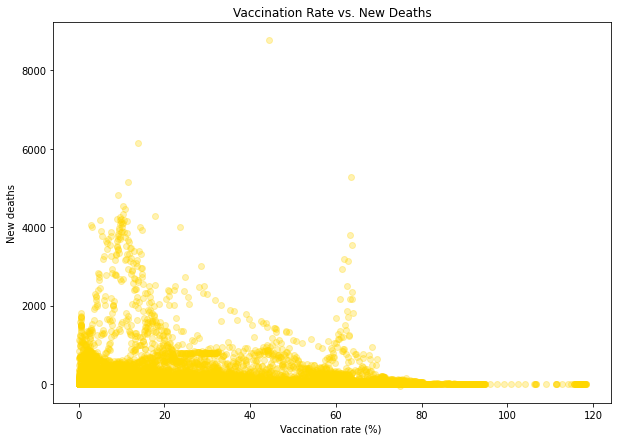

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(df.ratio, df.New_deaths,  color='gold', alpha=0.3)
plt.title('Vaccination Rate vs. New Deaths')
plt.xlabel("Vaccination rate (%) ")
plt.ylabel("New deaths")
plt.show()

Yes -- as one could imagine, although we can observe that there appears to exhibit a downward-sloping trend, the plot is not really useful because the pattern of vaccination rate vs. number of new deaths can be very different from country to country. A more useful presentation of the relationship would be to select a specific country and make the country-specific plot. 

In [ ]:
'''
  Function to create a scatter plot of vaccination rate vs. 
  number of new deaths for the given country

  Input:
    country_name: name of the given country
'''
def plot_vaccine_mortality(country_name):
  plt.figure(figsize=(10,7))
  plt.scatter(df[df['country'] == country_name].ratio, 
        df[df['country'] == country_name].New_deaths,  
        color='gold', alpha=0.3)
  plt.title(country_name)
  plt.xlabel("Vaccination Rate (%) ")
  plt.ylabel("New Deaths")
  plt.show()

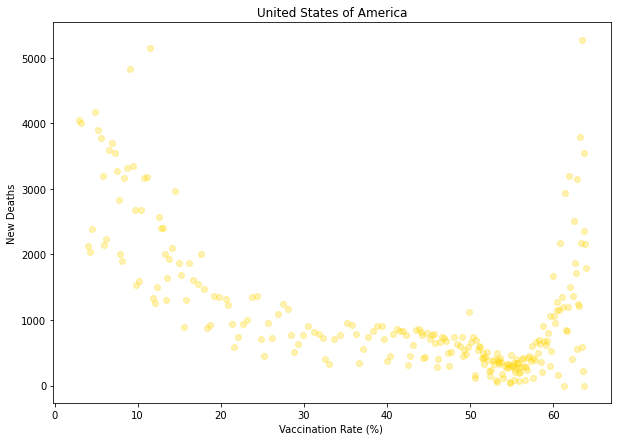

In [ ]:
plot_vaccine_mortality('United States of America')

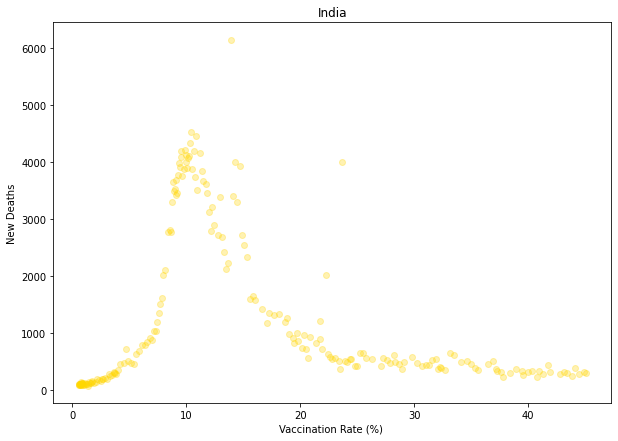

In [ ]:
plot_vaccine_mortality('India')

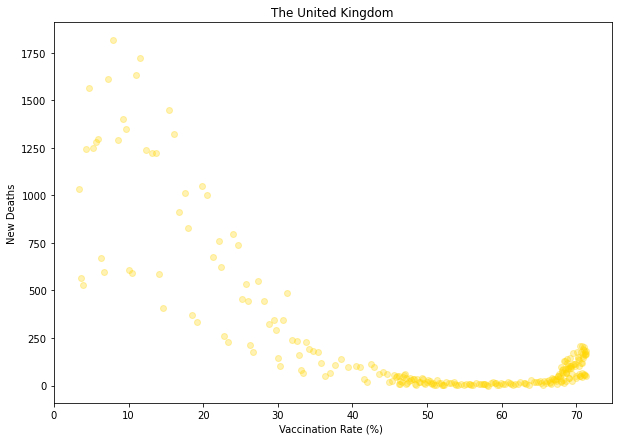

In [ ]:
plot_vaccine_mortality('The United Kingdom')

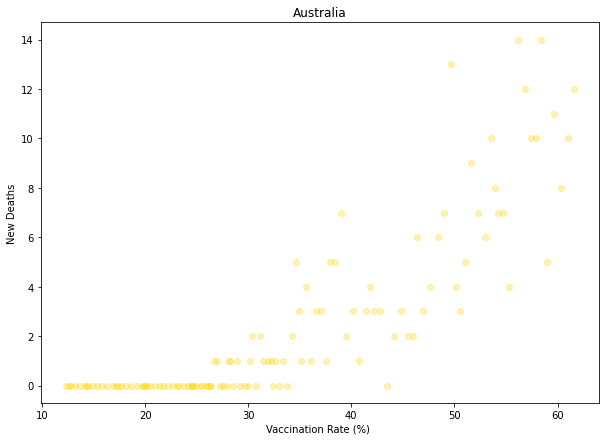

In [ ]:
plot_vaccine_mortality('Australia')

By arbitrarily taking the example of vaccination rate vs. the number of new deaths in the US, India, the UK, and Australia, we can observe that the pattern is quite different across different countries. In this case, a simple linear regression might not work well for all countries, and we will want to split the data into a country-by-country case instead of working with the entire dataset as an overall problem.

## Model Training and Evaluation
Since a simple linear regression may not produce the best fit model, we will need to do some tweaks and tricks to it. In an earlier project, I have used the **PolynomialFeatures** to transform the data into a higher degree for the linear regression model.

For our feature selection, because the dataset is relatively simple and the features are somewhat overlapping in nature, the input feature will only be the **ratio** and the target label will be the **New_deaths** (i.e. we will try to predict mortality from vaccination rate).

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

In [ ]:
'''
  Function to create a plot of scatter points for real data, 
  predicted data, and best fit line generated by the model.

  Input:
    country_name: name of given country
    degree: the degree for polynimial features
'''
def plot_vaccine_mortality_poly(country_name, degree=4):
  country_df = df[df['country'] == country_name]

  if len(country_df) > 10:
    # Do train-test split
    X = np.array(country_df['ratio']).reshape(-1, 1) 
    y = np.array(country_df['New_deaths']).reshape(-1, 1) 
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                            test_size=0.2,
                            random_state=42)

    # Transform features into polynomial
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.fit_transform(X_test)
    X_poly = poly.fit_transform(X)

    # Fit the model
    clf = LinearRegression(normalize=True)
    y_train_ = clf.fit(X_train_poly, y_train)
    y_fit = clf.predict(X_poly) # best fit on the entire X
    y_pred = clf.predict(X_test_poly)

    # Set the X- and Y-axis for the model function
    X_axis = np.arange(X[0], X[-1], 0.1)
    Y_axis = clf.intercept_[0]
    for deg in range(1, degree + 1):
      Y_axis += clf.coef_[0][deg] * np.power(X_axis, deg)
      
    plt.figure(figsize=(10,7))

    # Plot the model function
    plt.plot(X_axis, Y_axis, 'blue')

    # Plot the actual data
    plt.scatter(df[df['country'] == country_name].ratio, 
          df[df['country'] == country_name].New_deaths,  
          color='gold', alpha=0.5)
      
    # Plot the model prediction on actual data
    plt.scatter(X, 
          y_fit,
          color='green', marker="^", alpha=0.3)

    plt.title(country_name)
    plt.xlabel("Vaccination Rate (%) ")
    plt.ylabel("New Deaths")
    plt.show()
      
    # Evaluate the model by R-square score and MSE
    r2 = r2_score(y_test, y_pred)
    print(f"R2-score: \t\t{r2:.2f}")
    MSE = np.mean((y_pred - y_test) ** 2)
    print(f"Mean Square Error: \t{MSE:.2f}")
  else:
    print("The dataset contains less than 10 rows of record and may not produce accurate result.")

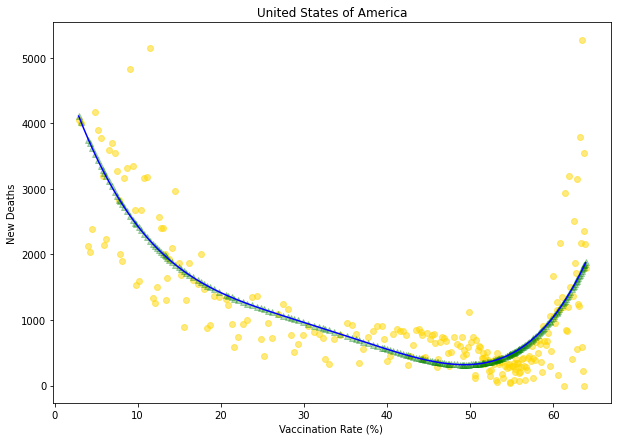

R2-score: 		0.58
Mean Square Error: 	498600.19


In [ ]:
plot_vaccine_mortality_poly("United States of America", degree=4)

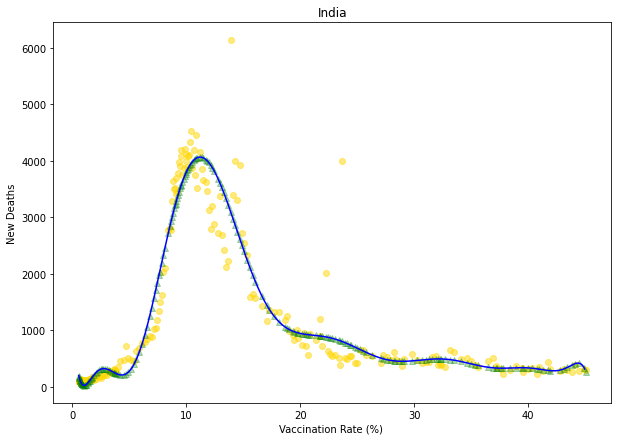

R2-score: 		0.95
Mean Square Error: 	109783.52


In [ ]:
plot_vaccine_mortality_poly("India", degree=13)

Using a degree of 13 for the polynomial features will generate a highly fit line for the data of India, but in most cases this is not recommended because it imposes the potential problem of overfitting to the training data. In other words, it may predict mortality well for the training data that covers vaccination between 0 to 45%, but it will not produce a good estimation of mortality for a vaccination rate of, say, 60%.

In most cases, using a degree of 4 to 8 will be sufficient enough to generate a model that can best fit and well generalize to the data.

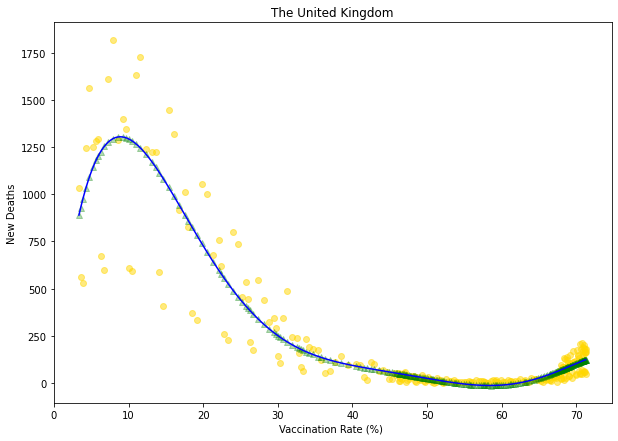

R2-score: 		0.79
Mean Square Error: 	44119.34


In [ ]:
plot_vaccine_mortality_poly("The United Kingdom", degree=6)

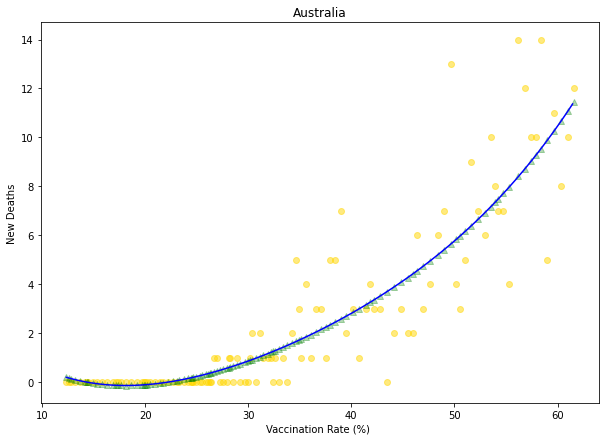

R2-score: 		0.78
Mean Square Error: 	3.80


In [ ]:
plot_vaccine_mortality_poly("Australia")

In [ ]:
plot_vaccine_mortality_poly("Madagascar")

The dataset contains less than 10 rows of record and may not produce accurate result.


As we can see from the model results in the examples above, differrnt countries exhibit different (and quite interesting) relationship between vaccination rate and mortality.

In the case of the US, India, and the UK, there at least shows a somewhat inverse relationship between vaccination rate and mortality: when the vaccination rate increases, the number of new deaths decreases. However, for the US and UK, it is interesting to note that mortality decreases initially as vaccination rate increases; however, when the ratio of vaccinated passes around 50% and 60% in the US and UK, repsectively, the number of new deaths increases. This certainly goes against our intuition of how higher vaccination rate should be negatively correlated to mortality.

For the special case like Australia, although the relationship between vaccination rate and mortality appears to be positive, it is worth noting that the number of new deaths has not exceeded 14 per day in the period. This is likely the result of Australia's strong policy and measures against the COVID-19 situation in the earlier part of the time period and the recent "outbreak" in Australia; any increase in mortality will thus lead to a slightly misleading trend.